# Heart Rate Estimation using PPG (Convolutional Neural Networks)

The data has to be downloaded from [here](https://archive.ics.uci.edu/ml/datasets/PPG-DaLiA), unzipped into the current folder. Different folders for each individual has to be in the same directory as this notebook.

In [1]:
import pickle
import numpy as np
from math import floor
from tqdm import tqdm
lengths=[]
activities = []
ppg = []
lines = []
X = []
for i in tqdm(range(1,16)):
   st ='S'+str(i)+'/'+'S'+str(i)+'.pkl'
   with open(st, 'rb') as f:
       temp = pickle.load(f, encoding='latin1')
   ppg = temp['signal']['wrist']['BVP'].tolist()
   qppg =[]
   lengths.append(int(len(ppg)/128)-3)
   ac = temp['activity']
   tempac =[]
   for l in range(int(floor(ac.shape[0]/8))-3):
       activities.append(max(ac[l*8:(l+4)*8]))
   #print(len(activities),len(temp['label']))
   for p in range(int(len(ppg)/128)-3):
       t = np.zeros(512)
       k = 0
       for j in range(p*128,(4+p)*128):
           t[k] = ppg[j][0]
           k = k+1
       qppg.append(t)
   X.extend(qppg)
   lines.extend(temp['label'])
   #activities.extend(temp['activity'].tolist())
   #print(i)


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:35<00:00, 10.34s/it]


In [2]:
import numpy as np
X=np.array(X)

In [3]:
Y = []
for i in lines:
    t = np.zeros(1)
    t[0]=i
    Y.append(t)
Y = np.array(Y)

X and Y has the input and output data for training the model. The total data accounted for 64697 samples and each input sample is of size 512.

In [4]:
print(X.shape,Y.shape)

(64697, 512) (64697, 1)


The input and output data is spiltted into train and test set using sklearn's train-test split

In [5]:
import scipy
import numpy as np
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.10, random_state=42)

We've used keras to train the RNN model. The model has been defined with various layers as shown below and activated with relu for the hidden layers and compiled with Adam optimisation.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, Reshape, MaxPooling1D, Flatten

max_words=512
model = Sequential()
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Reshape((1,4,128)))
model.add(Conv1D(256,3,activation='relu',input_shape=[4,128]))
model.add(Reshape((4,128)))
model.add(MaxPooling1D(pool_size=2))
model.add(Reshape((1,4,64)))
model.add(Conv1D(256,3,activation='relu',input_shape=[4,128]))
model.add(Reshape((4,128)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')
print(model.metrics_names)

[]


We also use callbacks with early stopping with a patience of 15 and Model checkpoint to save the model.

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(monitor='loss', patience=15),
             ModelCheckpoint('cnn_model.h5', save_best_only=True, 
                             save_weights_only=False)]

Run the below code to load the trained model and evaluate.

In [ ]:
batch_size = 64
epochs = 300

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,callbacks=callbacks,validation_data=(X_test,y_test), verbose=1)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)

Run the below code to load the trained model and evaluate.

In [8]:
import keras
loaded=keras.models.load_model('cnn_model.h5')

Run the below code to get the predictions of all the samples which can be used to compare and evaluate.

In [9]:
y_pred = loaded.predict(X)
y_predict=[]
for i in range(y_pred.shape[0]):
    y_predict.append(y_pred[i][0][0])

Get all the accuracy metrics using the code below.

In [10]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(Y, y_predict))  
print('MSE:', metrics.mean_squared_error(Y, y_predict))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y, y_predict)))
print('VarScore:',metrics.explained_variance_score(Y,y_predict))

MAE: 1.8749540341978441
MSE: 6.558102436072701
RMSE: 2.560879231059657
VarScore: 0.9875726118003614


Run the code below to plot a graph to see how far away the predictions are from the ground truth.

Text(0, 0.5, 'Predicted')

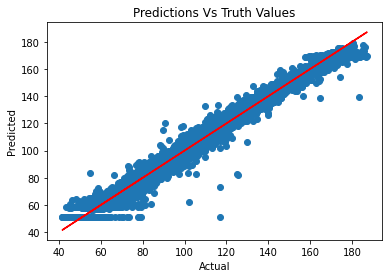

In [11]:
# Visualizing Our predictions
import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(10,5))
plt.scatter(Y,y_predict)
plt.plot(Y,Y,'r')
plt.title('Predictions Vs Truth Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
#plt.savefig('figures_final/predictions_cnn.png')

Compare the predicted heart rate vs ground truth for all the individuals

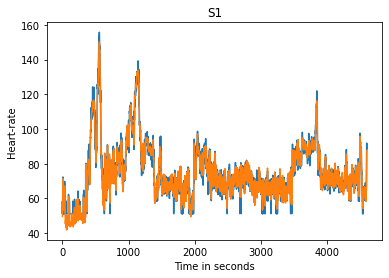

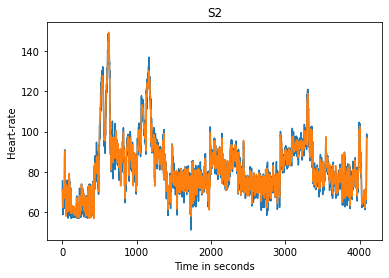

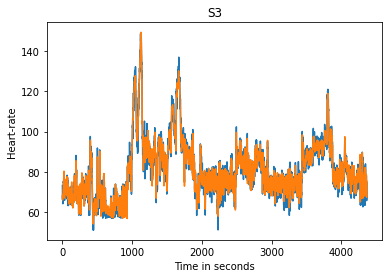

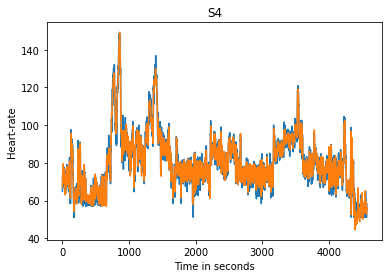

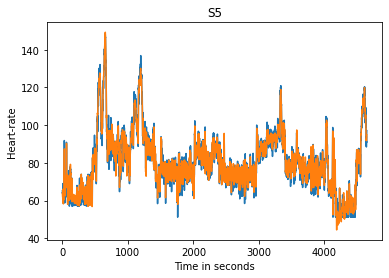

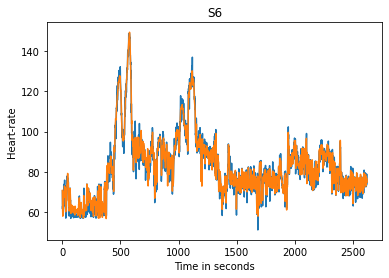

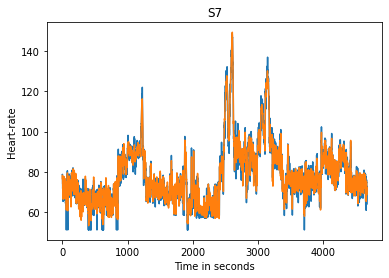

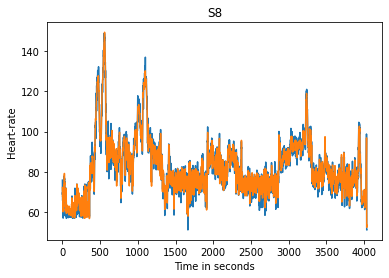

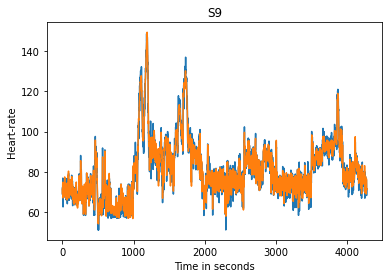

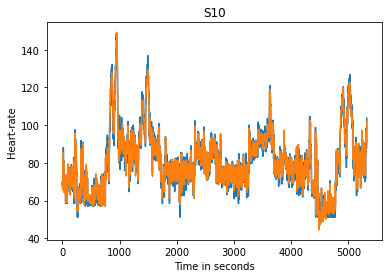

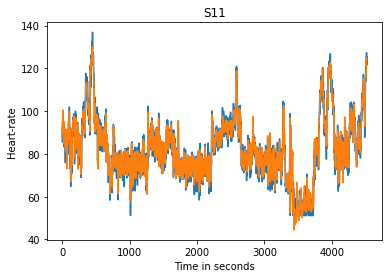

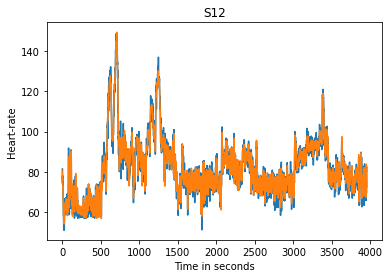

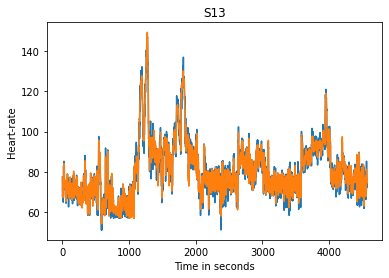

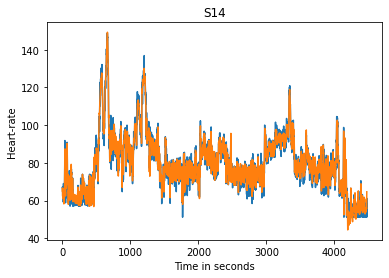

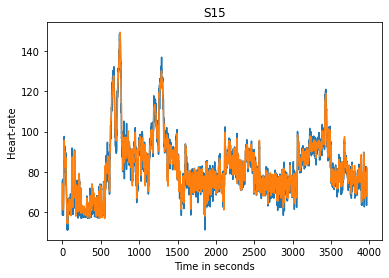

In [12]:
counter=0
for i in range(1,16):
    #plt.subplot(15,1,i)
    xaxis=range(lengths[i-1])
    yaxis=y_predict[counter:lengths[i-1]+counter]
    yaxis1=Y[counter:lengths[i-1]+counter]
    counter= lengths[i-1]
    plt.plot(xaxis,yaxis)
    plt.plot(xaxis,yaxis1)
    plt.title('S'+str(i))
    plt.xlabel('Time in seconds')
    plt.ylabel('Heart-rate')
    plt.show()
    #plt.savefig('figures_final/S'+str(i)+'_cnn.png')
    #plt.clf()

Compare how fast the heart rate is changing by getting the difference between adjacent heart rates for both predicted and ground truth heart rates.

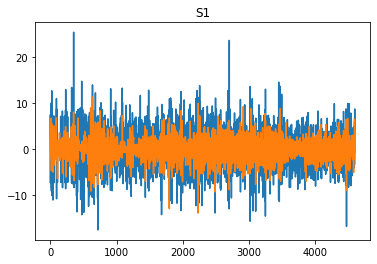

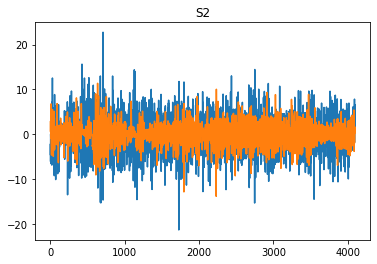

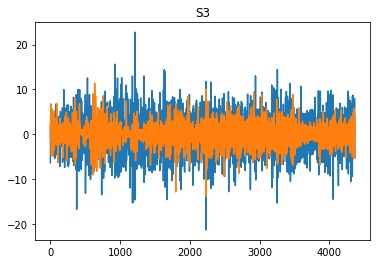

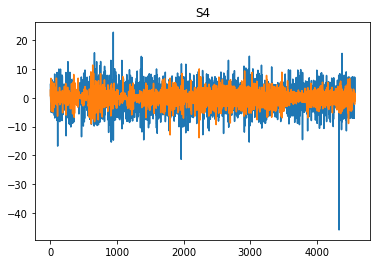

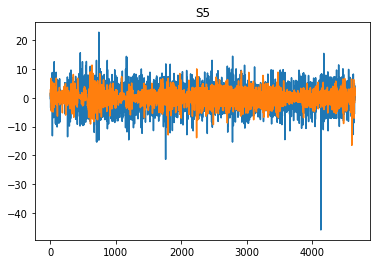

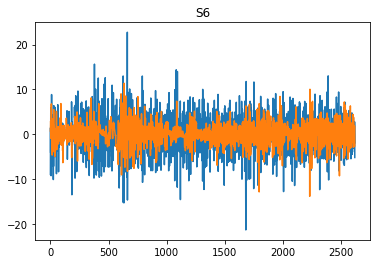

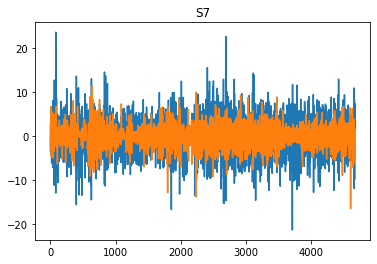

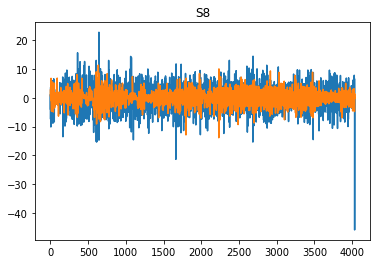

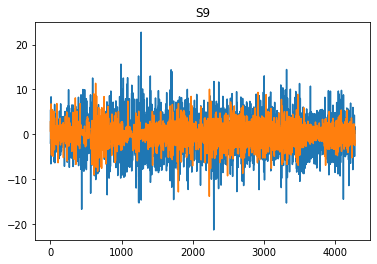

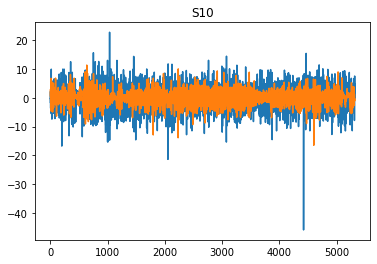

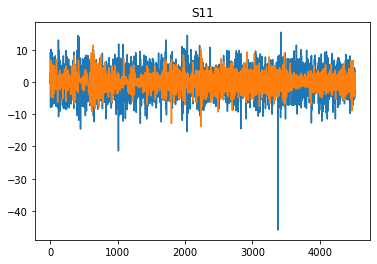

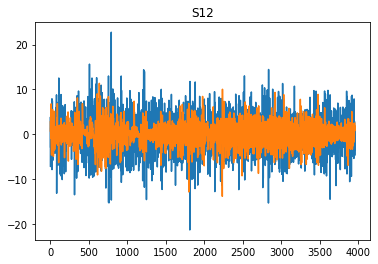

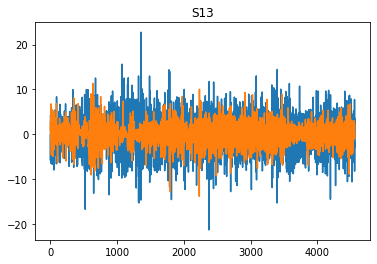

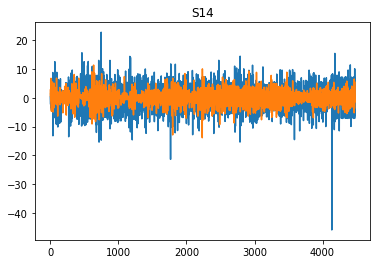

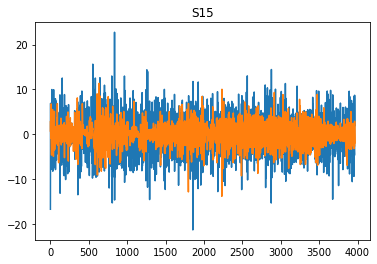

In [13]:
import matplotlib.pyplot as plt
counter =0
for i in range(1,16):
    #plt.subplot(15,1,i)
    xaxis=range(lengths[i-1]-1)
    yaxis = y_predict[counter:lengths[i-1]+counter]
    yaxis1=Y[counter:lengths[i-1]+counter]
    diff_list1 = []
    diff_list2 = []
    diff = 0
    for j in range(1,len(yaxis)):
        diff_list1.append(yaxis[j]-yaxis[j-1])
        diff_list2.append(Y[j]-Y[j-1])
    counter= lengths[i-1]
    plt.plot(xaxis,diff_list1)
    plt.plot(xaxis,diff_list2)
    plt.title('S'+str(i))
    plt.show()
    #plt.savefig('figures_final/S'+str(i)+'_diff_cnn.png')
    #plt.clf()

Check the accuracy for different thresholds by running the code below.

In [14]:
y_acc = []
x_acc = []
threshold = 1
while threshold < 10:
   counter =0
   for i in range(len(y_predict)):
       if abs(Y[i][0]-y_predict[i])<threshold:
           counter +=1
   y_acc.append((counter/y_pred.shape[0])*100)
   x_acc.append(threshold)
   threshold += 0.1

Plot error margin vs accuracy over threshold values from 1 through 10.

Text(0, 0.5, 'Accuracy')

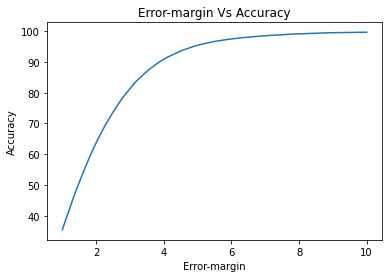

In [15]:
import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(10,5)) 
plt.plot(x_acc,y_acc)
plt.title('Error-margin Vs Accuracy')
plt.xlabel('Error-margin')
plt.ylabel('Accuracy')
#plt.savefig('figures_final/errorvsacc_graph_cnn.png')

Find out and plot the error-margin vs accuracy for different activities for error-margin from 1 through 10.

In [16]:
acts = [[0 for i in range(10)] for j in range(9)]
 
for threshold in range(1,11):
   counter = 0
   positives = [0,0,0,0,0,0,0,0,0]
   totals = [0,0,0,0,0,0,0,0,0]
   for i in range(y_pred.shape[0]):
       if abs(Y[i][0]-y_pred[i])<threshold:
           positives[int(activities[i])]+=1
       totals[int(activities[i])]+=1
   for i in range(9):
       acts[i][threshold-1]=positives[i]/totals[i]

Text(0.5, 1.0, 'Error-margin Vs Accuracy for Different activities')

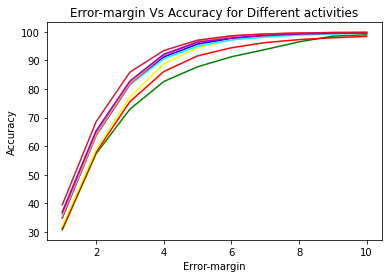

In [17]:
colr =['b','g','r','yellow','cyan','magenta','orange','darkviolet','crimson']
for i in range(9):
   plt.plot(range(1,11),[j*100 for j in acts[i]],color=colr[i])
plt.xlabel("Error-margin")
plt.ylabel("Accuracy")
plt.title("Error-margin Vs Accuracy for Different activities")
#plt.savefig('figures_final/act_cnn.png')